##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Data augmentation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/data_augmentation"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

This tutorial demonstrates data augmentation: a technique to increase the diversity of your training set by applying random (but realistic) transformations, such as image rotation.

You will learn how to apply data augmentation in two ways:

- Use the Keras preprocessing layers, such as `tf.keras.layers.Resizing`, `tf.keras.layers.Rescaling`, `tf.keras.layers.RandomFlip`, and `tf.keras.layers.RandomRotation`.
- Use the `tf.image` methods, such as `tf.image.flip_left_right`, `tf.image.rgb_to_grayscale`, `tf.image.adjust_brightness`, `tf.image.central_crop`, and `tf.image.stateless_random*`.

## Setup

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

## Download a dataset

This tutorial uses the [tf_flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers) dataset. For convenience, download the dataset using [TensorFlow Datasets](https://www.tensorflow.org/datasets). If you would like to learn about other ways of importing data, check out the [load images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.


In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.OILQ2G_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


The flowers dataset has five classes.

In [ ]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


Let's retrieve an image from the dataset and use it to demonstrate data augmentation.

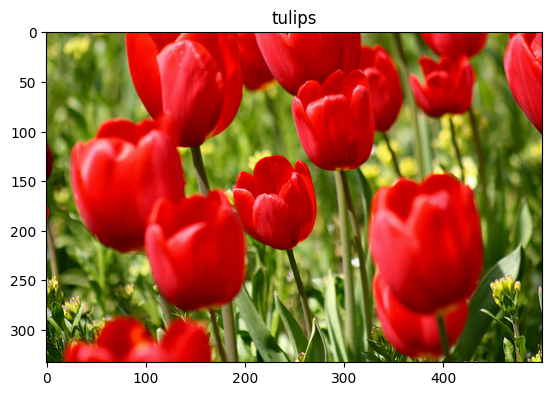

In [ ]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

## Use Keras preprocessing layers

### Resizing and rescaling


You can use the Keras preprocessing layers to resize your images to a consistent shape (with `tf.keras.layers.Resizing`), and to rescale pixel values (with `tf.keras.layers.Rescaling`).

In [ ]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

Note: The rescaling layer above standardizes pixel values to the `[0, 1]` range. If instead you wanted it to be `[-1, 1]`, you would write `tf.keras.layers.Rescaling(1./127.5, offset=-1)`.


You can visualize the result of applying these layers to an image.

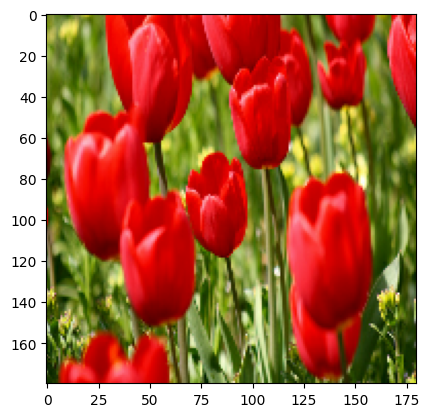

In [ ]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

Verify that the pixels are in the `[0, 1]` range:

In [ ]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


### Data augmentation

You can use the Keras preprocessing layers for data augmentation as well, such as `tf.keras.layers.RandomFlip` and `tf.keras.layers.RandomRotation`.

Let's create a few preprocessing layers and apply them repeatedly to the same image.

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

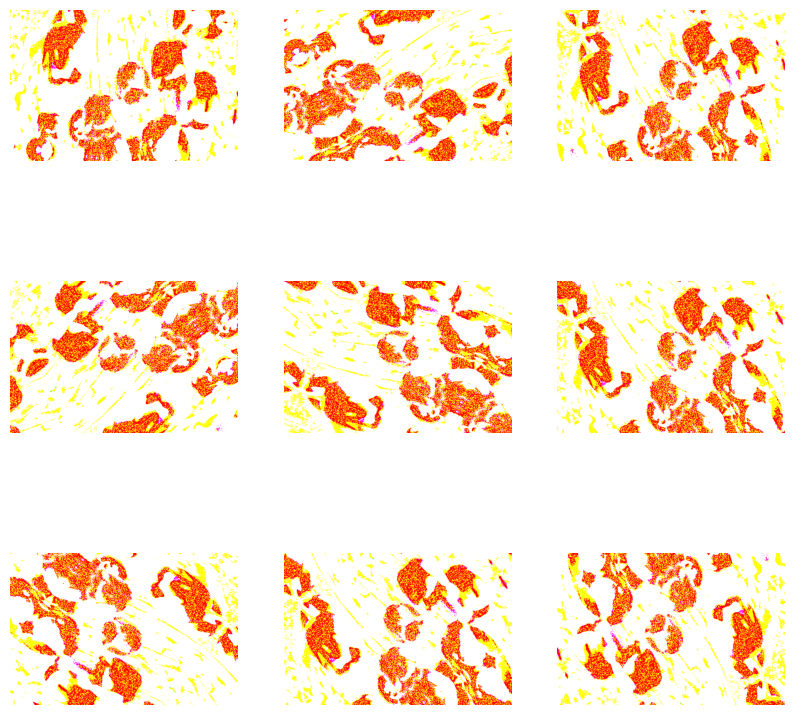

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

There are a variety of preprocessing layers you can use for data augmentation including `tf.keras.layers.RandomContrast`, `tf.keras.layers.RandomCrop`, `tf.keras.layers.RandomZoom`, and others.

### Two options to use the Keras preprocessing layers

There are two ways you can use these preprocessing layers, with important trade-offs.

#### Option 1: Make the preprocessing layers part of your model

In [ ]:
model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model.
])

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "functional_1" is incompatible with the layer: expected shape=(None, 333, 500, 3), found shape=(180, 180, 3)[0m

Arguments received by Sequential.call():
  • args=('<KerasTensor shape=(180, 180, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor_7>',)
  • kwargs={'mask': 'None'}

There are two important points to be aware of in this case:

* Data augmentation will run on-device, synchronously with the rest of your layers, and benefit from GPU acceleration.

* When you export your model using `model.save`, the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). This can save you from the effort of having to reimplement that logic server-side.

Note: Data augmentation is inactive at test time so input images will only be augmented during calls to `Model.fit` (not `Model.evaluate` or `Model.predict`).

#### Option 2: Apply the preprocessing layers to your dataset

In [ ]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

With this approach, you use `Dataset.map` to create a dataset that yields batches of augmented images. In this case:

* Data augmentation will happen asynchronously on the CPU, and is non-blocking. You can overlap the training of your model on the GPU with data preprocessing, using `Dataset.prefetch`, shown below.
* In this case the preprocessing layers will not be exported with the model when you call `Model.save`. You will need to attach them to your model before saving it or reimplement them server-side. After training, you can attach the preprocessing layers before export.


You can find an example of the first option in the [Image classification](classification.ipynb) tutorial. Let's demonstrate the second option here.

### Apply the preprocessing layers to the datasets

Configure the training, validation, and test datasets with the Keras preprocessing layers you created earlier. You will also configure the datasets for performance, using parallel reads and buffered prefetching to yield batches from disk without I/O become blocking. (Learn more dataset performance in the [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance) guide.)

Note: Data augmentation should only be applied to the training set.

In [ ]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

### Train a model

For completeness, you will now train a model using the datasets you have just prepared.

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for accuracy (the goal is to show you the mechanics).

In [ ]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Train for a few epochs:

In [ ]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

### Custom data augmentation

You can also create custom data augmentation layers.

This section of the tutorial shows two ways of doing so:

- First, you will create a `tf.keras.layers.Lambda` layer. This is a good way to write concise code.
- Next, you will write a new layer via [subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models), which gives you more control.

Both layers will randomly invert the colors in an image, according to some probability.

In [ ]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [ ]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

Next, implement a custom layer by [subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models):

In [ ]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

In [ ]:
_ = plt.imshow(RandomInvert()(image)[0])

Both of these layers can be used as described in options 1 and 2 above.

## Using tf.image

The above Keras preprocessing utilities are convenient. But, for finer control, you can write your own data augmentation pipelines or layers using `tf.data` and `tf.image`. (You may also want to check out [TensorFlow Addons Image: Operations](https://www.tensorflow.org/addons/tutorials/image_ops) and [TensorFlow I/O: Color Space Conversions](https://www.tensorflow.org/io/tutorials/colorspace).)

Since the flowers dataset was previously configured with data augmentation, let's reimport it to start fresh:

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Retrieve an image to work with:

In [ ]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

Let's use the following function to visualize and compare the original and augmented images side-by-side:

In [ ]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

### Data augmentation

#### Flip an image

Flip an image either vertically or horizontally with `tf.image.flip_left_right`:

In [ ]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

#### Grayscale an image

You can grayscale an image with `tf.image.rgb_to_grayscale`:

In [ ]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

#### Saturate an image

Saturate an image with `tf.image.adjust_saturation` by providing a saturation factor:

In [ ]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

#### Change image brightness

Change the brightness of image with `tf.image.adjust_brightness` by providing a brightness factor:

In [ ]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

#### Center crop an image

Crop the image from center up to the image part you desire using `tf.image.central_crop`:

In [ ]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

#### Rotate an image

Rotate an image by 90 degrees with `tf.image.rot90`:

In [ ]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

### Random transformations

Warning: There are two sets of random image operations: `tf.image.random*` and `tf.image.stateless_random*`. Using `tf.image.random*` operations is strongly discouraged as they use the old RNGs from TF 1.x. Instead, please use the random image operations introduced in this tutorial. For more information, refer to [Random number generation](../../guide/random_numbers.ipynb).

Applying random transformations to the images can further help generalize and expand the dataset. The current `tf.image` API provides eight such random image operations (ops):

*   [`tf.image.stateless_random_brightness`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_brightness)
*   [`tf.image.stateless_random_contrast`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_contrast)
*   [`tf.image.stateless_random_crop`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_crop)
*   [`tf.image.stateless_random_flip_left_right`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_flip_left_right)
*   [`tf.image.stateless_random_flip_up_down`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_flip_up_down)
*   [`tf.image.stateless_random_hue`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_hue)
*   [`tf.image.stateless_random_jpeg_quality`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_jpeg_quality)
*   [`tf.image.stateless_random_saturation`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_saturation)

These random image ops are purely functional: the output only depends on the input. This makes them simple to use in high performance, deterministic input pipelines. They require a `seed` value be input each step. Given the same `seed`, they return the same results independent of how many times they are called.

Note: `seed` is a `Tensor` of shape `(2,)`  whose values are any integers.

In the following sections, you will:
1.   Go over examples of using random image operations to transform an image.
2.   Demonstrate how to apply random transformations to a training dataset.

#### Randomly change image brightness

Randomly change the brightness of `image` using `tf.image.stateless_random_brightness` by providing a brightness factor and `seed`. The brightness factor is chosen randomly in the range `[-max_delta, max_delta)` and is associated with the given `seed`.

In [ ]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_brightness = tf.image.stateless_random_brightness(
      image, max_delta=0.95, seed=seed)
  visualize(image, stateless_random_brightness)

#### Randomly change image contrast

Randomly change the contrast of `image` using `tf.image.stateless_random_contrast` by providing a contrast range and `seed`. The contrast range is chosen randomly in the interval `[lower, upper]` and is associated with the given `seed`.

In [ ]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_contrast = tf.image.stateless_random_contrast(
      image, lower=0.1, upper=0.9, seed=seed)
  visualize(image, stateless_random_contrast)

#### Randomly crop an image

Randomly crop `image` using `tf.image.stateless_random_crop` by providing target `size` and `seed`. The portion that gets cropped out of `image` is at a randomly chosen offset and is associated with the given `seed`.

In [ ]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_crop = tf.image.stateless_random_crop(
      image, size=[210, 300, 3], seed=seed)
  visualize(image, stateless_random_crop)

### Apply augmentation to a dataset

Let's first download the image dataset again in case they are modified in the previous sections.

In [ ]:
(train_datasets, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Next, define a utility function for resizing and rescaling the images. This function will be used in unifying the size and scale of images in the dataset:

In [ ]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

Let's also define the `augment` function that can apply the random transformations to the images. This function will be used on the dataset in the next step.

In [ ]:
def augment(image_label, seed):
  image, label = image_label
  image, label = resize_and_rescale(image, label)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
  # Make a new seed.
  new_seed = tf.random.split(seed, num=1)[0, :]
  # Random crop back to the original size.
  image = tf.image.stateless_random_crop(
      image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
  # Random brightness.
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.5, seed=new_seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

#### Option 1: Using tf.data.experimental.Counter

Create a `tf.data.experimental.Counter` object (let's call it `counter`) and `Dataset.zip` the dataset with `(counter, counter)`. This will ensure that each image in the dataset gets associated with a unique value (of shape `(2,)`) based on `counter` which later can get passed into the `augment` function as the `seed` value for random transformations.

In [ ]:
# Create a `Counter` object and `Dataset.zip` it together with the training set.
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_datasets, (counter, counter)))

Map the `augment` function to the training dataset:

In [ ]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

#### Option 2: Using tf.random.Generator

- Create a `tf.random.Generator` object with an initial `seed` value. Calling the `make_seeds` function on the same generator object always returns a new, unique `seed` value.
- Define a wrapper function that: 1) calls the `make_seeds` function; and 2) passes the newly generated `seed` value into the `augment` function for random transformations.

Note: `tf.random.Generator` objects store RNG state in a `tf.Variable`, which means it can be saved as a [checkpoint](../../guide/checkpoint.ipynb) or in a [SavedModel](../../guide/saved_model.ipynb). For more details, please refer to [Random number generation](../../guide/random_numbers.ipynb).

In [ ]:
# Create a generator.
rng = tf.random.Generator.from_seed(123, alg='philox')

In [ ]:
# Create a wrapper function for updating seeds.
def f(x, y):
  seed = rng.make_seeds(1)[:, 0]
  image, label = augment((x, y), seed)
  return image, label

Map the wrapper function `f` to the training dataset, and the `resize_and_rescale` function—to the validation and test sets:

In [ ]:
train_ds = (
    train_datasets
    .shuffle(1000)
    .map(f, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [ ]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

These datasets can now be used to train a model as shown previously.

## Next steps

This tutorial demonstrated data augmentation using Keras preprocessing layers and `tf.image`.

- To learn how to include preprocessing layers inside your model, refer to the [Image classification](classification.ipynb) tutorial.
- You may also be interested in learning how preprocessing layers can help you classify text, as shown in the [Basic text classification](../keras/text_classification.ipynb) tutorial.
- You can learn more about `tf.data` in this [guide](../../guide/data.ipynb), and you can learn how to configure your input pipelines for performance [here](../../guide/data_performance.ipynb).